In [53]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd
import matplotlib as mpl
import scipy

In [54]:
# somehow shae of ca times is chaned in notebook -> Why??
print(ca_trace.shape,times_calcium.shape,noise_stimulus.shape)

(10284,) (10284,) (15, 20, 1500)


In [55]:
# Load data
ca_trace = np.load('toydata/trace.npy')
noise_stimulus = np.load('toydata/noise_stimulus.npy')
noise_stimulus = np.transpose(noise_stimulus,axes=(2,1,0))
noise_times = np.load('toydata/trig_ts.npy')
times_calcium = np.load('toydata/ts_trace.npy')
roi_dict = {"Triggertimes_noise":noise_times,
            "Traces0_raw_noise":ca_trace, 
            "Tracetimes0_noise":times_calcium,
            "roi_id": 0,
            "rec_id": 1,
            "cell_id": 20200708

            }

cell_id = 20200708

In [56]:
# interpolate noise? wh???
def get_stim_and_calcium(one_roi):
    """Interpolates the noise stimulus and align it temporally with calcium."""
            
    noise_times = one_roi["Triggertimes_noise"]
    calcium_at_roi = one_roi["Traces0_raw_noise"]
    times_calcium = one_roi["Tracetimes0_noise"]

    # Throw out calcium from before the noise.
    condition = times_calcium > np.min(noise_times)
    calcium_at_roi = calcium_at_roi[condition]
    times_calcium = times_calcium[condition]

    # Throw out calcium from after 200ms after the last noise trigger.
    condition = times_calcium < np.max(noise_times) + 0.2
    calcium_at_roi = calcium_at_roi[condition]
    times_calcium = times_calcium[condition]
    
    interpolated_noise = np.zeros((noise_stimulus.shape[0], noise_stimulus.shape[1], len(times_calcium)))  # np.interp(times_calcium, joined_times, joined_stim)
    for i in range(15):
        for j in range(20):
            interpolator = scipy.interpolate.interp1d(noise_times, noise_stimulus[i, j], kind="zero", fill_value="extrapolate")
            interpolated_noise[i, j, :] = interpolator(times_calcium)

    # Align calcium and stimulus.
    temporal_delay_steps = 10
    calcium_at_roi = calcium_at_roi[temporal_delay_steps:]
    times_calcium = times_calcium[temporal_delay_steps:]
    interpolated_noise = interpolated_noise[:, :, :-temporal_delay_steps]

    return interpolated_noise, calcium_at_roi, times_calcium, noise_times

In [57]:
interpolated_noise, calcium_at_roi, times_calcium, noise_times = get_stim_and_calcium(roi_dict)

In [58]:
def lowpass_calcium(df):
    noise_times = one_roi["Triggertimes_noise"]
    calcium_at_roi = one_roi["Traces0_raw_noise"]
    times_calcium = one_roi["Tracetimes0_noise"]

    # Throw out calcium from before the noise.
    condition = times_calcium > np.min(noise_times)
    calcium_at_roi = calcium_at_roi[condition]
    times_calcium = times_calcium[condition]

    # Throw out calcium from after 400ms after the last noise trigger.
    condition = times_calcium < np.max(noise_times) + 0.4
    calcium_at_roi = calcium_at_roi[condition]
    times_calcium = times_calcium[condition]

    mean_calcium = np.mean(calcium_at_roi)
    std_calcium = np.std(calcium_at_roi)
    raw_calcium = (calcium_at_roi - mean_calcium) / std_calcium
    sos = signal.butter(4, 7.0, 'low', fs=31.25, output='sos')
    filtered_calcium = signal.sosfilt(sos, raw_calcium)
    return filtered_calcium, raw_calcium, times_calcium, noise_times


def delay_and_subsample_calcium(calcium, times_calcium, noise_times, temporal_delay_steps: int = 5):
    interpolated_noise = np.zeros((noise_stimulus.shape[0], noise_stimulus.shape[1], len(times_calcium)))
    noise_index = np.arange(noise_stimulus.shape[2])
    noise_times = noise_times[:1500]
    interpolator = scipy.interpolate.interp1d(noise_times, noise_index, kind="zero", fill_value="extrapolate")
    interpolated_index = interpolator(times_calcium)

    calcium = calcium[temporal_delay_steps:]
    times_calcium = times_calcium[temporal_delay_steps:]
    interpolated_noise_index = interpolated_index[:-temporal_delay_steps]

    diff_X = np.concatenate([np.diff(interpolated_noise_index), [0]]) > 0.0
    last_calcium_per_image = calcium[diff_X]
    last_time_per_image = times_calcium[diff_X]

    return last_calcium_per_image, last_time_per_image

In [59]:
one_roi = roi_dict
filtered_calcium, raw_calcium, times_calcium, noise_times = lowpass_calcium(one_roi)
subsampled_calcium, subsampled_times = delay_and_subsample_calcium(
    filtered_calcium, 
    times_calcium, 
    noise_times, 
    temporal_delay_steps=5
)

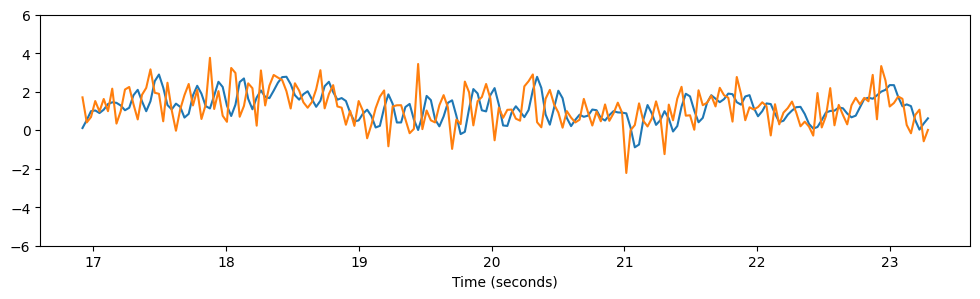

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
_ = ax.plot(times_calcium[:200], filtered_calcium[:200])
_ = ax.plot(times_calcium[:200], raw_calcium[:200])
_ = ax.set_xlabel("Time (seconds)")
_ = ax.set_ylim([-6, 6])

# Is there an additional preprocessing step they take?? dFF or one that we take??

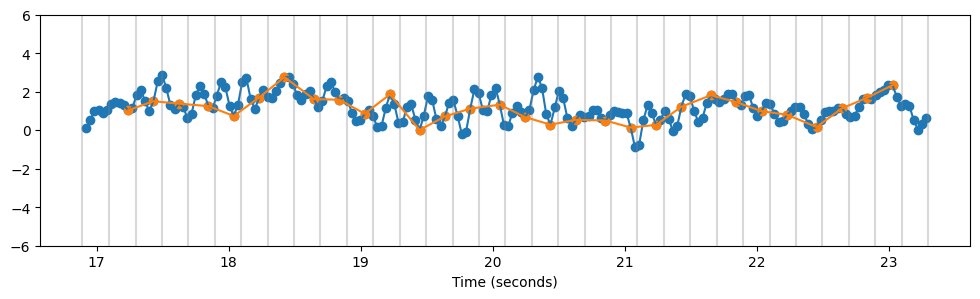

In [61]:
ig, ax = plt.subplots(1, 1, figsize=(12, 3))
_ = ax.plot(times_calcium[:200], filtered_calcium[:200])
_ = ax.scatter(times_calcium[:200], filtered_calcium[:200])

for i in range(33):
    _ = ax.axvline(noise_times[i], c="gray", alpha=0.3)

_ = ax.plot(subsampled_times[:30], subsampled_calcium[:30])
_ = ax.scatter(subsampled_times[:30], subsampled_calcium[:30])

_ = ax.set_xlabel("Time (seconds)")
_ = ax.set_ylim([-6, 6])

# linear regerssion for optimal time lag ??? common ?? 

In [62]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from scipy.spatial.distance import correlation

In [63]:
all_accs_across_rois = []
shifts = np.arange(6, 14)

one_roi = roi_dict
filtered, _, times_calcium, noise_times = lowpass_calcium(one_roi)
all_accs = []
for i in shifts:
    subsampled_calcium, subsampled_times = delay_and_subsample_calcium(
        filtered, 
        times_calcium, 
        noise_times, 
        temporal_delay_steps=i
    )

    data = noise_stimulus.reshape((300, 1500)).T[:1498]
    target = subsampled_calcium[:1498]

    clf = LinearRegression()
    shuffle = KFold(n_splits=5, shuffle=True, random_state=0)
    scores = cross_val_score(
        clf, data, target, cv=shuffle, scoring="neg_mean_absolute_error", verbose=0
    )
    cross_val_acc = np.mean(scores)
    all_accs.append(cross_val_acc)
print("acc", np.asarray(all_accs) + 1.0)
all_accs_across_rois.append(all_accs)

acc [0.2836381  0.29885697 0.29295741 0.2694096  0.27948195 0.28680739
 0.28058559 0.28738893]


average_acc [0.2836381  0.29885697 0.29295741 0.2694096  0.27948195 0.28680739
 0.28058559 0.28738893]
best shift:  7


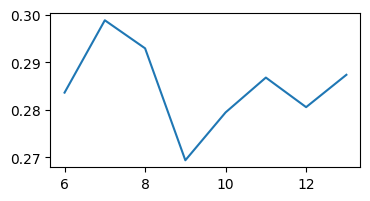

In [64]:
average_acc = np.mean(all_accs_across_rois, axis=0) + 1.0
print("average_acc", average_acc)
best_shift = shifts[np.argmax(average_acc)]
print("best shift: ", best_shift)

fig, ax = plt.subplots(1, 1, figsize=(4, 2))
_ = ax.plot(shifts, average_acc)

In [99]:
inds = []
cell_ids = []
rec_ids = []
roi_ids = []
labels = []

index = 0
one_roi = roi_dict
roi_ids.append(one_roi["roi_id"])
rec_ids.append(one_roi["rec_id"])
cell_ids.append(one_roi["cell_id"])
inds.append(index)

filtered, _, times_calcium, noise_times = lowpass_calcium(one_roi)
subsampled_calcium, subsampled_times = delay_and_subsample_calcium(
    filtered, 
    times_calcium, 
    noise_times, 
    temporal_delay_steps=best_shift
)
labels.append(subsampled_calcium[:1498].tolist())

In [86]:
import os 
save_dir = !pwd
save_dir = os.path.join(save_dir[0],'toydata')
assert os.path.isdir(save_dir)
print(save_dir)

/home/samuel/uni/lr2/jaxley_rgc/toydata


In [ ]:
labels = pd.DataFrame().from_dict(
    {
        "inds": inds,
        "cell_id": cell_ids,
        "rec_id": rec_ids,
        "roi_id": roi_ids,
        "ca": labels, 
    }
)



In [101]:
labels.to_pickle(f"{save_dir}/labels_lowpass_{cell_id}.pkl")